<a href="https://colab.research.google.com/github/brendabo1/CNN-classification-CUFS/blob/main/cnn_face_sketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras
!pip install tensorflow

In [3]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, UpSampling2D, Dropout, Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [4]:
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import collections

In [5]:
import os

!pip install kaggle
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"

def list_files_in_folder(folder_path):
  """Lists all files in a given folder."""
  try:
    file_list = os.listdir(folder_path)
    return file_list
  except FileNotFoundError:
    print(f"Error: Folder not found at {folder_path}")
    return []

photos_folder = "photos"
files_in_photos = list_files_in_folder(photos_folder)

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 99% 112M/113M [00:00<00:00, 203MB/s] 
100% 113M/113M [00:00<00:00, 169MB/s]


In [5]:
print(files_in_photos)
print(len(files_in_photos))

['f-020-01.jpg', 'f-016-01.jpg', 'm1-021-01.jpg', 'm-021-01.jpg', 'm-009-01.jpg', 'm-045-01.jpg', 'm-074-01.jpg', 'm-076-01.jpg', 'f1-011-01.jpg', 'm1-022-01.jpg', 'f1-009-01.jpg', 'f-017-01.jpg', 'm-055-01.jpg', 'm-031-01.jpg', 'm-093-01.jpg', 'm-037-01.jpg', 'f-007-01.jpg', 'm-094-01.jpg', 'm1-011-01.jpg', 'f1-013-01.jpg', 'm-044-01.jpg', 'f-015-01.jpg', 'm-081-01.jpg', 'f-022-01.jpg', 'm-090-01.jpg', 'm1-014-01.jpg', 'f-032-01.jpg', 'm-030-01.jpg', 'm1-002-01.jpg', 'm-026-01.jpg', 'f1-014-01.jpg', 'f-012-01.jpg', 'f-010-01.jpg', 'm-028-01.jpg', 'm-010-01.jpg', 'f1-008-01.jpg', 'm-100-01.jpg', 'm-099-01.jpg', 'f-034-01.jpg', 'm1-007-01.jpg', 'm-068-01.jpg', 'm-018-01.jpg', 'm1-005-01.jpg', 'm1-027-01.jpg', 'm1-018-01.jpg', 'm1-033-01.jpg', 'm-082-01.jpg', 'm-096-01.jpg', 'm1-031-01.jpg', 'm-058-01.jpg', 'f-027-01.jpg', 'm1-006-01.jpg', 'm-095-01.jpg', 'f-026-01.jpg', 'f-037-01.jpg', 'm-069-01.jpg', 'm-091-01.jpg', 'm-036-01.jpg', 'm-089-01.jpg', 'm1-034-01.jpg', 'f-011-01.jpg', 'm1-0

(250, 200, 3)

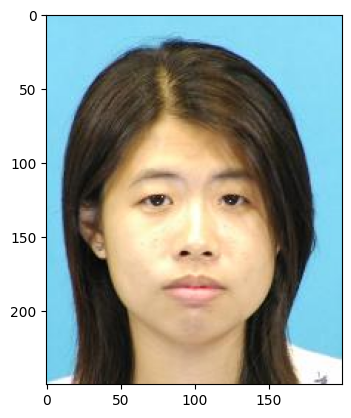

In [6]:
def exibir_imagens(lista_nomes):
  for img_name in lista_nomes:
    print(img_name)
    img_path = f"photos/{img_name}"
    img = image.load_img(img_path)
    plt.imshow(img)

img_path = f"photos/f-010-01.jpg"
img = image.load_img(img_path)
plt.imshow(img)
cv2.imread("photos/f-010-01.jpg").shape


### Preparação das imagens

In [6]:
img_array = []
genero = []
ALTURA = 250
LARGURA = 200

target_size = (200, 250)  # (largura, altura)

for img_name in tqdm(files_in_photos):
    genero_label = 1 if img_name.startswith('f') else 0  # 0 - masculino, 1 - feminino
    img_path = f"photos/{img_name}"
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Aumentação de dados
    transformadas = [img]  # Adicionar a original
    transformadas.append(cv2.flip(img, 1))  # Flip horizontal
    transformadas.append(cv2.flip(img, 0))  # Flip vertical
    transformadas.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))  # Rotação 90° horário
    transformadas.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))  # Rotação 90° anti-horário

    for img_aug in transformadas:
        img_aug = cv2.resize(img_aug, target_size)
        img_array.append(img_to_array(img_aug))
        genero.append(genero_label)

try:
    images = np.array(img_array)
    genero = np.array(genero)
    print("Formato das imagens:", images.shape)
except Exception as e:
    print("Erro ao converter para numpy array:", e)

print("Total de imagens e rótulos:", images.shape[0], len(genero))
# Verificando as formas
# for i, img in enumerate(img_array):
#     print(f"Imagem {i} - Forma: {img.shape}")


100%|██████████| 188/188 [00:01<00:00, 148.64it/s]


Formato das imagens: (940, 250, 200, 3)
Total de imagens e rótulos: 940 940


## Dividindo o Dataset


* 50% para o conjunto de treinamento,
* 30% para o conjunto de validação
* 20% para o conjunto de teste: reservado para avaliar o desempenho final do modelo.Item de lista


Quantidade de imagens de treino: 470
Quantidade de imagens de validação: 282
Quantidade de imagens de test: 188

Distribuição no conjunto de treino: Masculino - 335, Feminino - 135
Distribuição no conjunto de validação: Masculino - 201, Feminino - 54
Distribuição no conjunto de teste: Masculino - 134, Feminino- 54


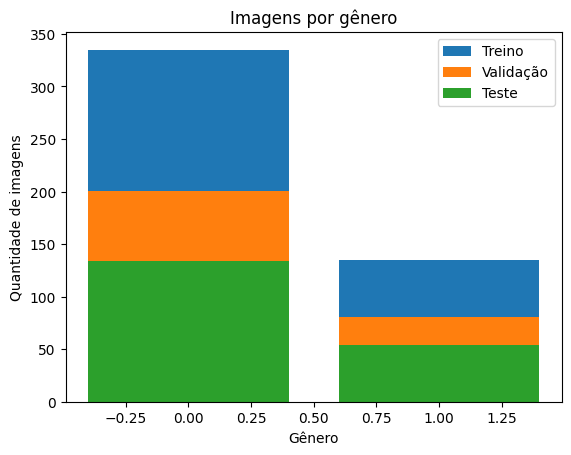

In [21]:
# Dividindo o dataset de treino em treino e validação de forma balanceada
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp  = train_test_split(images, genero, test_size=0.5, random_state=23, stratify=genero)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.4, random_state=23, stratify=y_train)


# Checando quantidade de imagens do dataset
print('Quantidade de imagens de treino:', x_train.shape[0])
print('Quantidade de imagens de validação:', x_val.shape[0])
print('Quantidade de imagens de test:', x_test.shape[0])

# print(type(x_train), x_train.shape)
# print(type(y_train), y_train.shape)
# print(type(x_val), x_val.shape)
# print(type(y_val), y_val.shape)

# Contando quantidade de imagens por categoria (masculino/feminino)
generos = ['Masculino', 'Feminino']

counterTrain=collections.Counter(y_train)
counterVal=collections.Counter(y_val)
counterTest=collections.Counter(y_test)

print(f"\nDistribuição no conjunto de treino: Masculino - {dict(counterTrain)[0]}, Feminino - {dict(counterTrain)[1]}")
print(f"Distribuição no conjunto de validação: Masculino - {dict(counterVal)[0]}, Feminino - {dict(counterTest)[1]}")
print(f"Distribuição no conjunto de teste: Masculino - {dict(counterTest)[0]}, Feminino- {dict(counterTest)[1]}")

# Plotando quantidade de imagens de cada genero
fig, ax = plt.subplots()
rects1 = ax.bar(counterTrain.keys(), counterTrain.values(), label='Treino')
rects2 = ax.bar(counterVal.keys(), counterVal.values(), label='Validação')
rects3 = ax.bar(counterTest.keys(), counterTest.values(), label='Teste')

ax.set_title('Imagens por gênero')
ax.set_ylabel('Quantidade de imagens')
ax.set_xlabel('Gênero')
ax.legend()
plt.show()

In [8]:
# Formatando o dataset para funcionar como entrada do Keras

x_train = x_train.reshape(x_train.shape[0], 250, 200, 3)
x_val = x_val.reshape(x_val.shape[0], 250, 200, 3)
x_test = x_test.reshape(x_test.shape[0], 250, 200, 3)

# Convertento valores dos pixels para float (garantindo precisão em operações de divisão por exemplo)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# Normalizando os valores dos pixels (valores entre 0 e 1).
x_train /= 255
x_val /= 255
x_test /= 255

In [9]:
# Inicializando a CNN

model = Sequential()
input_shape = (250, 200, 3)

# Comvolução com filtro 3x3
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
# Camada densa
#model.add(Dense(128, activation='relu'))
model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output
# model.add(Dense(2,activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 97, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 8, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,812,481 (25.99 MB)

 Trainable params: 6,812,481 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True, verbose=0)

# Efetuando o treinamento de 10 épocas com o dataset de treino e validando no dataset de validação
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=30, batch_size=16, shuffle=False, callbacks=[early_stoping,learning_rate_reduction])





Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.6408 - loss: 0.9410 - val_accuracy: 0.7128 - val_loss: 0.6331 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7161 - loss: 0.6065 - val_accuracy: 0.7128 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7162 - loss: 0.5824
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7161 - loss: 0.5827 - val_accuracy: 0.7128 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7161 - loss: 0.5578 - val_accuracy: 0.7128 - val_loss: 0.5702 - learning_rate: 5.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.7429 - loss: 0.5169 - val_accuracy: 0.7199 - val_loss: 0.5367 - learning_rate: 5.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7837 - loss: 0.4613 - val

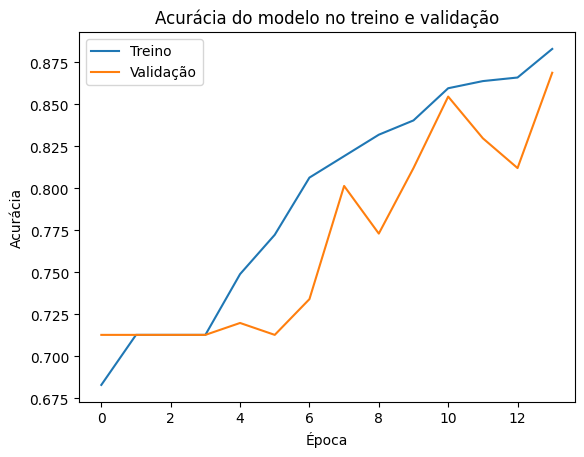

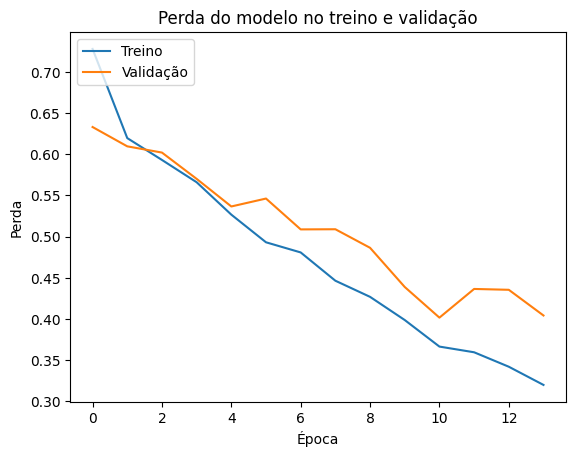

In [13]:
# Plotando o histórico de treino
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Histórico de acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo no treino e validação')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# # Histórico da função de perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo no treino e validação')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9104 - loss: 0.3619

Perda:0.428
Acurácia:0.8670212626457214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

O gênero predito da imagem é: Masculino


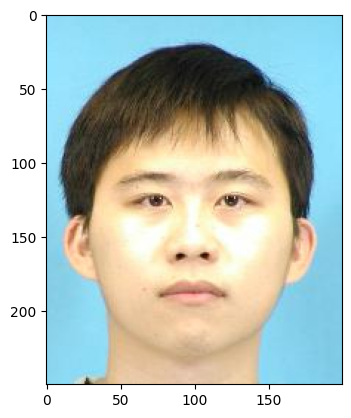

In [20]:
# Avaliando a CNN treinada
score = model.evaluate(x_test, y_test)

print( '\nPerda:{:.3f}\nAcurácia:{}'.format(score[0], score[1] ) )

# Imprimindo uma imagem de exemplo
image_index = 59
plt.imshow(x_test[image_index])

# Predizendo o dígito dessa imagem
pred = model.predict(x_test[image_index].reshape(1, 250, 200, 3) )
genero_previsto = pred.argmax()
if genero_previsto:
  print( '\nO gênero predito da imagem é: Feminino')
else:
  print( '\nO gênero predito da imagem é: Masculino')